In [73]:
import torch
import torch.nn.functional as F

import os, re

from src.models import rnn_sequence_model as stochseq
from src.models.rnn_sequence_model import get_data

In [10]:
def parse_filename(filename):
    # Define the regular expression pattern
    pattern = r"stochseq_model=(\w+)_layers=(\d+)_hidden=(\d+)\.pt"

    # Use regex to extract model and param
    match = re.match(pattern, filename)
    if match:
        model = match.group(1)
        layers = int(match.group(2))
        hidden = int(match.group(3))
        return model, layers, hidden
    else:
        return None

In [23]:
def find_matching_files(directory):
    files = os.listdir(directory)
    parsed = [(parse_filename(f), f) for f in files]
    
    return {x[0]: x[1] for x in parsed if x[0]}

In [24]:
models = find_matching_files('../models')

In [32]:
model = torch.load('../models/' + models[('GRU', 2, 4)])

In [33]:
model

SequenceModel(
  (rnn): GRU(2, 4, num_layers=2, batch_first=True)
  (linear): Linear(in_features=5, out_features=2, bias=True)
)

In [60]:
device='cuda'

In [61]:
# input is a (N, L) tensor where N are the number of batches and L is the length
def generate(model, input, device='cpu'):
    N, L = input.size()
    model.eval()
    with torch.no_grad():
        # the first x-value we feed into the RNN is zero, consistent with the training eamples
        pred = torch.zeros((N, 1, 1), device=device)
        predictions = []
        h_n = []
        for i in range(L):
            inp = torch.cat((input[:, i].reshape((N, 1, 1)), pred), dim=-1)
            
            output, hidden = model(inp)
            pred_mean, pred_var = output.split(1, dim=-1)
            pred = torch.normal(pred_mean, pred_var.sqrt())
            
            predictions.append(pred)
            h_n.append(hidden)
        predictions = torch.cat(predictions, dim=1).squeeze(2)
        
        return predictions, h_n

In [132]:
def cross_cov(data, transpose=False):
    if transpose:
        data = data.transpose(0, 1)
    N, L = data.shape[1:]
    result = F.conv1d(data, data, padding=L) / N / L
    return torch.arange(-L,L+1), result.transpose(0, 1).cpu()

In [65]:
val_data = torch.load('../data/gaussian_data.pt')['validation'].to(device)

In [134]:
cov.size()

torch.Size([2, 2, 201])

In [135]:
kappa = 0.5
lamda = 1.0
rho = 1.0
mu = 1.0

sigma_ss = kappa / lamda
sigma_sx = rho * sigma_ss / (lamda + mu)
sigma_xx = rho / mu * (sigma_ss + sigma_sx)

def exp2(x, decay, scale):
    return scale * (-decay * x).exp()

def exprel(x):
    return torch.where(x.abs() > 1e-15, torch.special.expm1(x) / x, 1.0)

def cov_ss(t):
    return exp2(t, lamda, sigma_ss)

def cov_sx(t):
    scale1 = rho * sigma_ss * t * exprel((lamda - mu) * t)
    return exp2(t, mu, sigma_sx) + exp2(t, lamda, scale1)

def cov_xs(t):
    return exp2(t, lamda, sigma_sx)

def cov_xx(t):
    scale1 = rho * sigma_sx * t * exprel((lamda - mu) * t)
    return exp2(t, lamda, scale1) + exp2(t, mu, sigma_xx)

In [136]:
t = torch.linspace(-10.0, 10.0, steps=cov.size(2))

In [137]:
true_cov = torch.stack((
    torch.stack((
        cov_ss(t.abs()),
        torch.where(t >= 0, cov_xs(t), cov_sx(-t)),
    )),
    torch.stack((
        torch.where(t >= 0, cov_sx(t), cov_xs(-t)),
        cov_xx(t.abs()),
    ))
))

In [138]:
from matplotlib import pyplot as plt

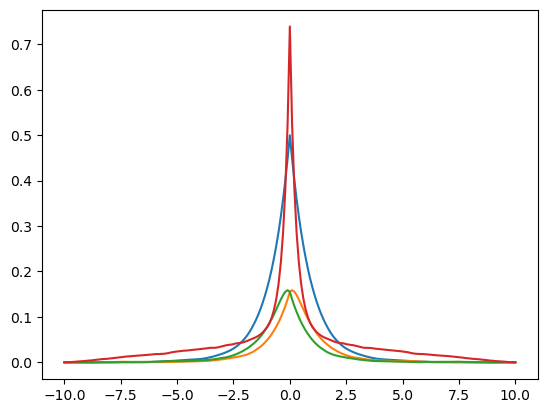

In [140]:
plt.plot(t, cov.flatten(0, 1).numpy().T)

In [143]:
F.mse_loss(cov, true_cov)

tensor(0.0060)

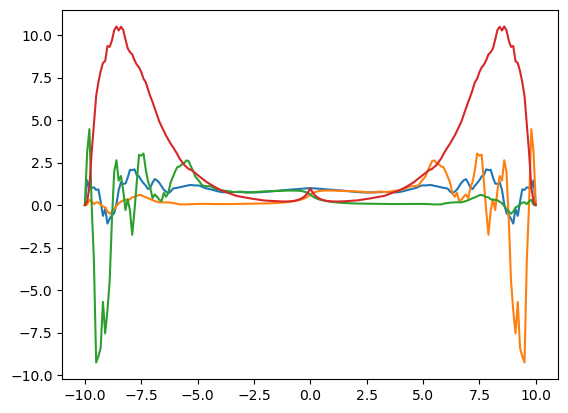

In [142]:
plt.plot(t, (cov / true_cov).flatten(0, 1).numpy().T)

In [156]:
def get_mse_loss(filename):
    model = torch.load('../models/' + filename)
    pred, _ = generate(model, val_data[:,0,:], device='cuda')
    lags, cov = cross_cov(torch.stack((val_data[:,0,:], pred)))
    return F.mse_loss(cov, true_cov).item()

hp_data = { p: get_mse_loss(f) for p, f in models.items() }

In [188]:
import numpy as np

In [214]:
cmap = { 'RNN': 'black', 'LSTM': 'green', 'GRU': 'red' }
markermap = {1: '.', 2: 'x'}
model_types = np.array([m for (m, _, _) in hp_data.keys()])
losses = np.fromiter(hp_data.values(), float)
layers = np.array([x for (_, x, _) in hp_data.keys()])
hidden = np.array([h for (_, _, h) in hp_data.keys()])
model_types, losses, layers, hidden

(array(['GRU', 'LSTM', 'RNN', 'LSTM', 'RNN', 'RNN', 'RNN', 'RNN', 'RNN',
        'RNN', 'RNN', 'RNN', 'RNN', 'RNN', 'RNN', 'GRU', 'GRU', 'GRU',
        'GRU', 'GRU', 'GRU', 'GRU', 'GRU', 'GRU', 'GRU', 'GRU', 'LSTM',
        'LSTM', 'LSTM', 'LSTM', 'LSTM', 'LSTM', 'LSTM', 'LSTM', 'LSTM',
        'LSTM'], dtype='<U4'),
 array([0.0060509 , 0.00734889, 0.34075052, 0.01010751, 0.00560061,
        0.00664357, 0.05388356, 0.01454386, 0.13516386, 0.02067578,
        0.01496102, 0.23825282, 0.59358448, 0.18531327, 0.24021842,
        0.00964267, 0.00871861, 0.00734953, 0.00877481, 0.00501408,
        0.00602775, 0.00414548, 0.00950981, 0.00750111, 0.00644173,
        0.00519784, 0.00731796, 0.00850859, 0.00718974, 0.00909638,
        0.01063078, 0.00978083, 0.00797897, 0.01060478, 0.00918279,
        0.00849062]),
 array([1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,
        2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2]),
 array([16, 16, 16,  8,  1,  1,  2,  2,  4,  4,  8,  8, 1

Text(0.5, 0, 'number hidden dimensions')

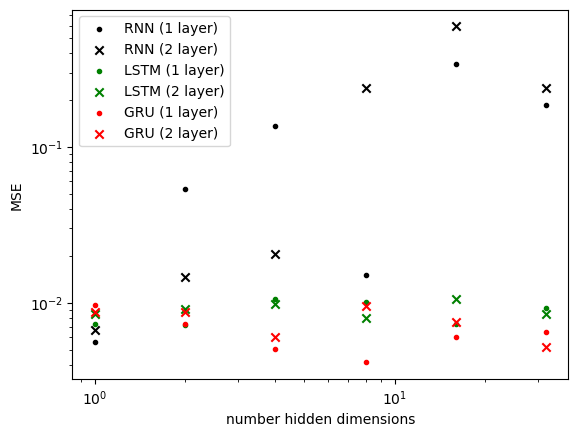

In [225]:
for model_type, c in cmap.items():
    for i, marker in markermap.items():
        mask = np.logical_and((model_types == model_type), (layers == i))
        plt.scatter(hidden[mask], losses[mask], label=f"{model_type} ({i} layer)", c=c, marker=marker)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylabel('MSE')
plt.xlabel('number hidden dimensions')